In [1]:
import numpy as np

def reszveny_arfolyam(
    kezdo_ar: float, 
    ido: float,
    atlag: float,
    szoras: float,
    lepes_szam: int = 252,
    utvonal_szam: int = 10000
) -> list:
    """
    Részvényár Itó-lemma alapú szimulációja 

    Args:
      kezdo_ar: Kezdő részvényárfolyam.
      ido: A modellezés időtartama.
      atlag: Az árfolyamváltozás átlagos iránya, %/év.
      szoras: Szórás (volatilitás) tag, amely a véletlen komponens mértékét határozza meg, %/év.
      lepes_szam: Az egy évben végzett megfigyelések száma. Átlagosan 252 kereskedési nap van évente a tőzsdén.
      utvonal_szam: A szimulált részvényárfolyamok száma.
  
    Returns:
      Szimulált árfolyam.
    """

    S = np.log(kezdo_ar)
    # az éves átlagot és szórást a megfigyelések gyakoriságához igazítjuk.
    atlag_t = atlag/lepes_szam
    sigma = szoras*np.sqrt(1/lepes_szam)
    # árfolyam változás
    dS_S_sorozatok = []
    # egy útvonal
    for _ in range(utvonal_szam):
        ez_az_ut = [0]
        for t in range(ido):
            # véletlenszerű lépés iránya
            dW = np.random.normal(0,1)
            # lépünk
            dS_S = (atlag_t-(sigma**2)/2)+sigma*dW
            ez_az_ut.append(dS_S)
        dS_S_sorozatok.append(ez_az_ut)

    # visszaalakítjuk valódi árrá a változásokat.
    S_t_sorozatok = [ np.exp(S+np.cumsum(walk)) for walk in dS_S_sorozatok ]

    return S_t_sorozatok

ido = 100
T = ido/252
bolyongasok = reszveny_arfolyam(
    kezdo_ar=100, 
    ido=ido,
    atlag=1.5,
    szoras=2,
    utvonal_szam=1000
)

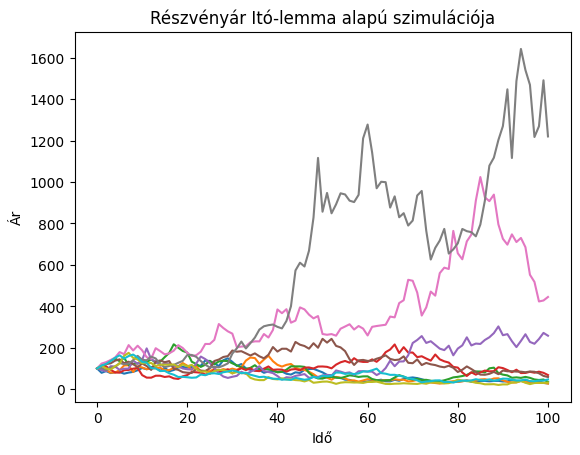

In [2]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.plot( bolyongasok[i] )
    
plt.xlabel("Idő")
plt.ylabel("Ár")
plt.title("Részvényár Itó-lemma alapú szimulációja")
plt.show()

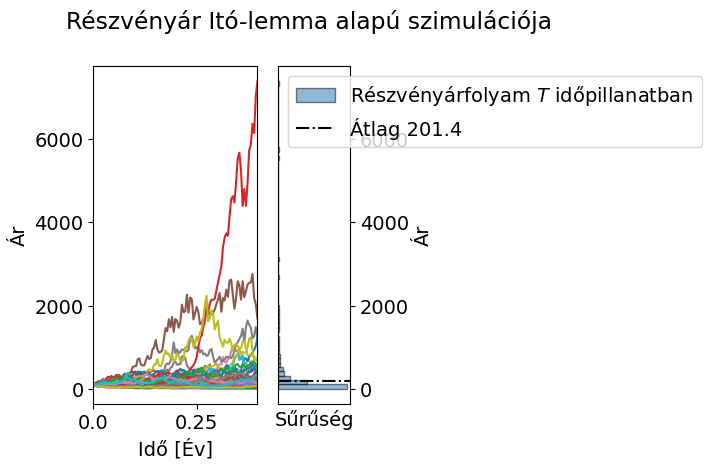

In [3]:
# Stock model prices
plt.clf()
plt.rcParams['figure.figsize'] = (18, 9)
plt.rcParams.update({'font.size': 14})
left = plt.subplot2grid((1, 3), (0, 0), rowspan=1, colspan=2)
S = [ x[-1] for x in bolyongasok ]

for i in range(100):
   left.plot(bolyongasok[i])
ticks = np.arange(0, ido, int(252/4))
plt.xticks(ticks, np.arange(0, T, 1/4))
plt.margins(x=0)
plt.ylabel('Ár')
plt.xlabel('Idő [Év]')


right = plt.subplot2grid((1, 3), (0, 2), rowspan=1, colspan=1)
right.hist(S, bins=70, alpha=0.5, ec='black', orientation="horizontal", label='Részvényárfolyam $T$ időpillanatban')
mean = np.mean(S)
plt.axhline(y=mean, c='black', ls='-.', label=f'Átlag {mean:.1f}')

plt.setp(plt.gca(), ylim=left.get_ylim())
plt.ylabel('Ár')
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.gca().set_xticks([])
plt.xlabel('Sűrűség')
plt.legend()

plt.subplots_adjust(wspace=0)
plt.gcf().suptitle(f'Részvényár Itó-lemma alapú szimulációja')
plt.tight_layout()
plt.show()

In [4]:
!pip install yahooquery --upgrade

In [5]:
import yahooquery as yq
import datetime

stocks = yq.Ticker("MSFT")
ar_msft = stocks.history("2y")
ar_msft = ar_msft.reset_index()
ar_msft = ar_msft.iloc[:-50,:]

C:\Users\Attila_Sajo\AppData\Local\miniconda3\envs\ds\Lib\site-packages\yahooquery\utils\__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
C:\Users\Attila_Sajo\AppData\Local\miniconda3\envs\ds\Lib\site-packages\yahooquery\ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)


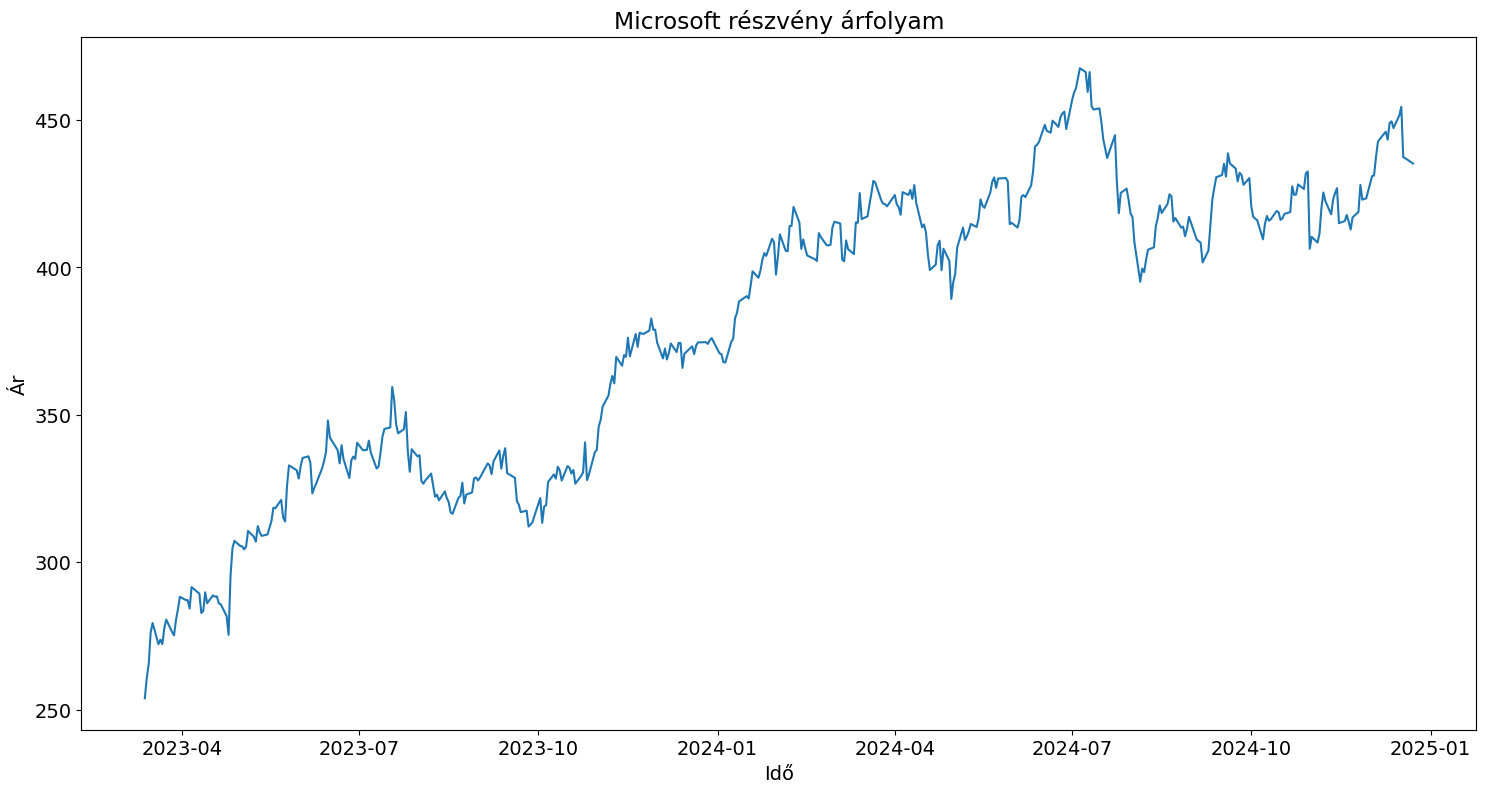

In [6]:
plt.plot(ar_msft["date"].values, ar_msft["close"].values)
plt.title("Microsoft részvény árfolyam")
plt.xlabel("Idő")
plt.ylabel("Ár")
plt.show()

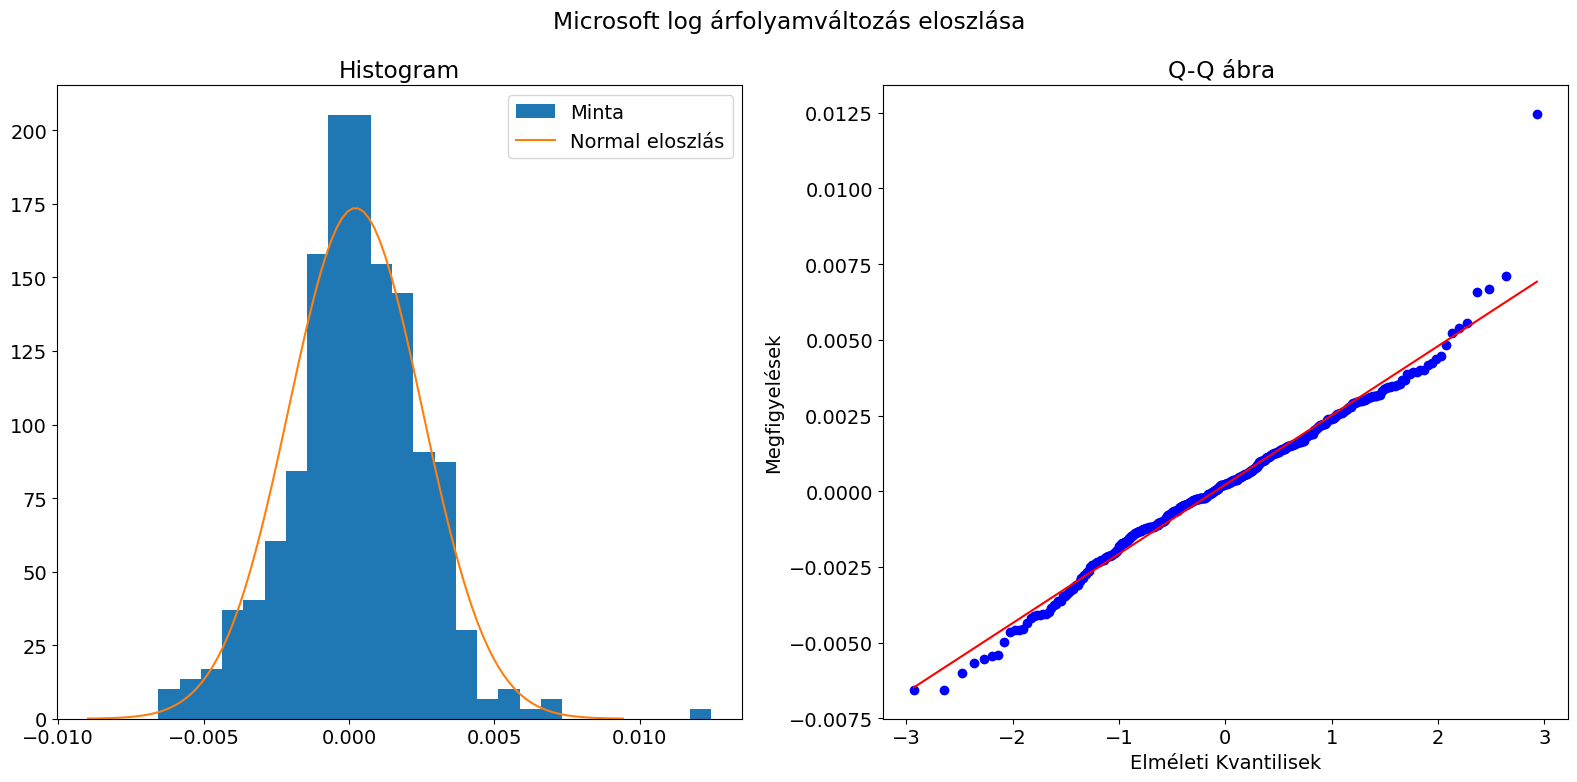

In [7]:
from scipy import stats

# előrejelzés hossza
T = 42
# tanulo adatok
arvaltozas = np.log(ar_msft["close"]).pct_change().values
# arvaltozas = ar_msft["close"].pct_change().values
obs = arvaltozas[1:-T]
obs_mean = np.mean(obs)
obs_std = np.std(obs)

fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
# minta
axes[0].hist(obs, bins=26, density=True, label="Minta")
# standard normál pdf sűrűségfüggvénye 
bins = np.linspace(obs_mean-4*obs_std, obs_mean+4*obs_std, 100)
normalpdf = stats.norm.pdf(bins, obs_mean, obs_std)
axes[0].plot(bins, normalpdf, label="Normal eloszlás")
axes[0].set_title("Histogram")
axes[0].legend()

# Q-Q ábra
plt.subplot(1,2,2)
stats.probplot(obs, dist="norm", plot=plt)
axes[1].set_title("Q-Q ábra ")
axes[1].set_xlabel("Elméleti Kvantilisek")
axes[1].set_ylabel("Megfigyelések")
fig.suptitle("Microsoft log árfolyamváltozás eloszlása")
plt.tight_layout()
plt.show()

Nincs autokorreláció.


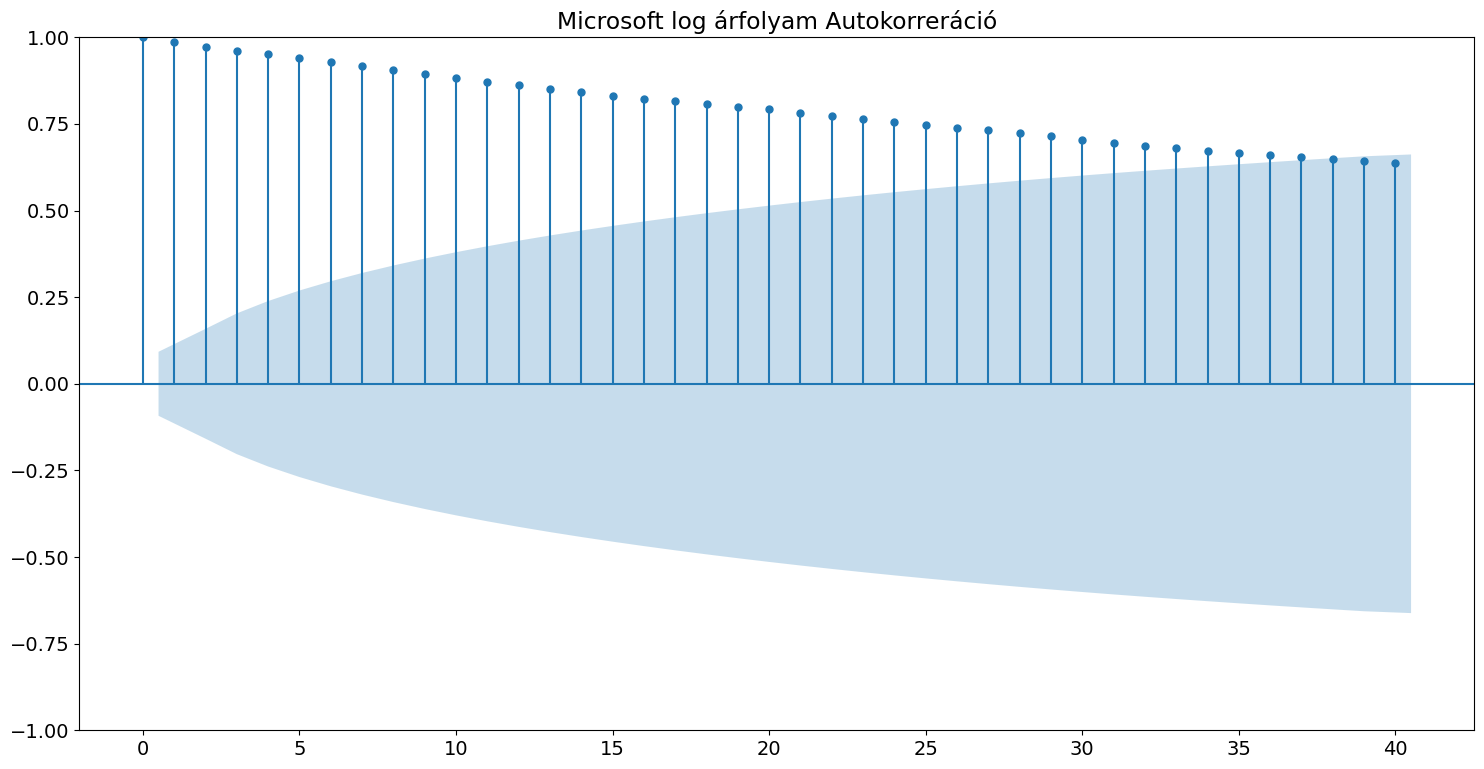

Van autokorreláció: r = -0.10407654777592877, lag = 2


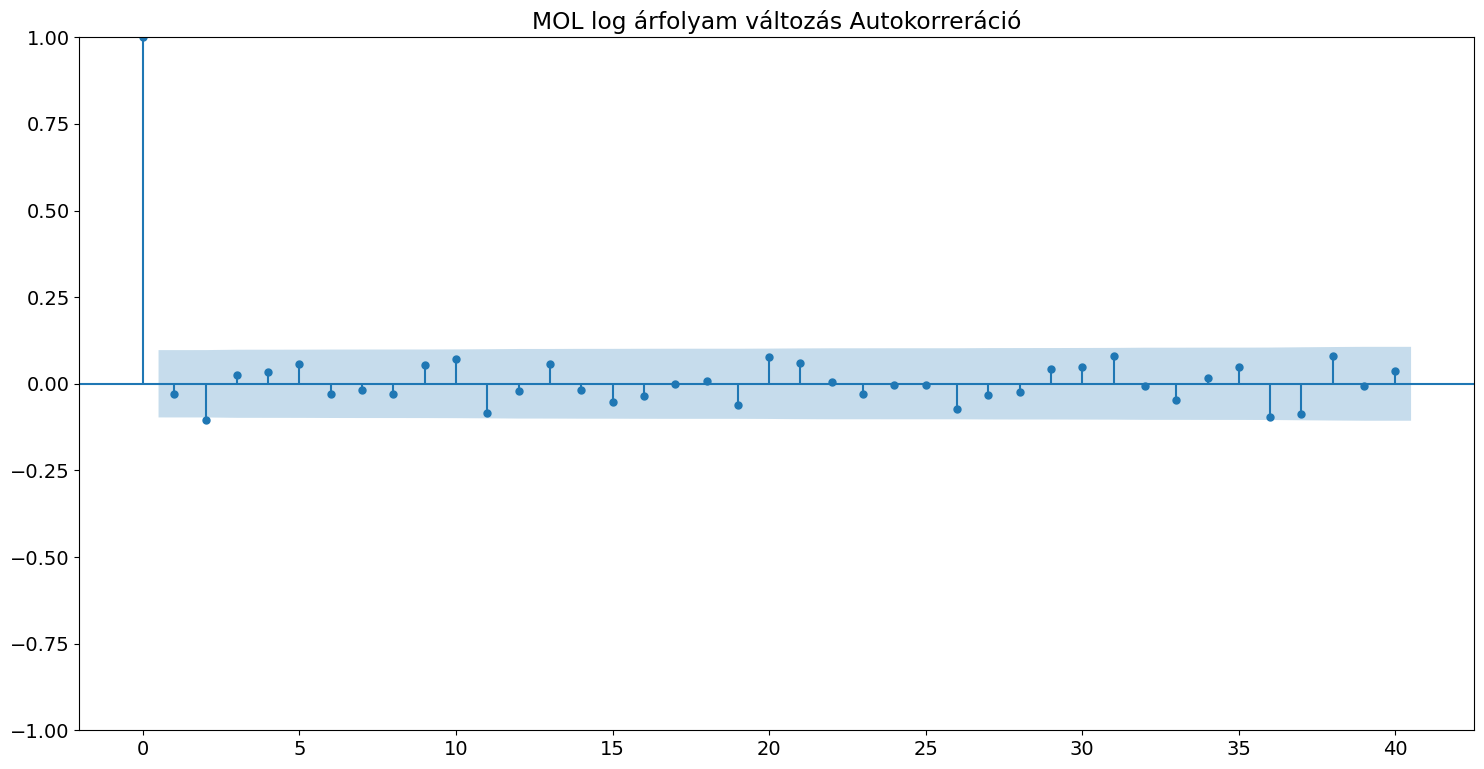

(-0.10407654777592877, 2)

In [8]:
from scipy.signal import argrelextrema
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
def autocorr(x, title="Autokorreráció", nlags=None):
    if nlags is None:
        nlags = x.shape[0]
    # autokorreláció 95% konfidencia intervallummal 
    acorr,confidence_interval = sm.tsa.acf(x, alpha=0.05, fft=True, nlags=nlags)
    confidence_interval[:, 0] = confidence_interval[:, 0]-acorr
    confidence_interval[:, 1] = confidence_interval[:, 1]-acorr
    lag = 1
    r = np.NaN
    pottential_lag = []
 
    # az optimális lag ahol acorr a konfidencia intervallumon kívül van
    # és a lokális min vagy max a legtávolabb van a szomszédjaitól
    maxs = argrelextrema(acorr, np.greater)
    maxs = maxs[0]
    for maxi in maxs:
        # a lokális maximum nagyobb mint 95%  konfidencia intervallumon
        if acorr[maxi] > confidence_interval[maxi, 1]:
            # távolság a két szomszédtól
            dist = np.abs(acorr[maxi]-acorr[maxi-1])+np.abs(acorr[maxi]-acorr[maxi+1])
            pottential_lag.append( 
                (dist, int(maxi))
            )
    mins = argrelextrema(acorr, np.less)
    mins = mins[0]
    for mini in mins:
        # a lokális minimum kisebb mint 95% konfidencia intervallumon
        if acorr[mini] < confidence_interval[mini, 0]:
            dist = np.abs(acorr[maxi-1]-acorr[maxi])+np.abs(acorr[maxi]-acorr[maxi+1])
            pottential_lag.append( 
                (dist, int(mini))
            )
     
    if len(pottential_lag) > 0:
        lag = sorted(pottential_lag)[-1][1]
        r = acorr[lag]        
    if lag > 1:
        print('Van autokorreláció: r = {}, lag = {}'. format(r, lag))
    else: 
        print('Nincs autokorreláció.')
    
    plot_acf(x, lags=40)
    plt.title(title)
    plt.show()
    
    
    return r, lag

autocorr(np.log(ar_msft["close"]), title="Microsoft log árfolyam Autokorreráció")
autocorr(obs, title="MOL log árfolyam változás Autokorreráció")


In [9]:
T = 42
# tanulo adatok
arvaltozas = ar_msft["close"].pct_change().values
# nem használjuk azokat a megfigyeléseket amit szimuláli akarunk 
obs = arvaltozas[1:-T]

# megfigyelés napi átlag
r_bar = obs.mean()
# megfigyelés napi szorása
s_r = np.sqrt(np.sum([ (o-r_bar)**2 for o in obs ] )/(len(obs)-1))
# éves szorás
dt = 1/252 # napi megfigyelés
sigma_hat = s_r/np.sqrt(dt)
# éves átlag
mu_hat = r_bar/dt - s_r**2/(2*dt)
print(f"Átlagos napi hozam százalékban = {np.round(r_bar,5)}")
print(f"Átlagos napi hozam szorása százalékban = {np.round(s_r,5)}")
print(f"Az Itó-lemma kalkulációval korrigált éves hozam százalékban = {np.round(mu_hat,8)}")
print(f"Az Itó-lemma kalkulációval korrigált éves szorás százalékban = {np.round(sigma_hat,8)}")

Átlagos napi hozam százalékban = 0.00135
Átlagos napi hozam szorása százalékban = 0.01352
Az Itó-lemma kalkulációval korrigált éves hozam százalékban = 0.31841958
Az Itó-lemma kalkulációval korrigált éves szorás százalékban = 0.21462819


In [10]:
dt = mu_hat*T/252
dW = s_r*np.sqrt(T)*1.96
S = np.log(ar_msft["close"].values[-T])

print(f"Legkisebb ár 95%-os valoszinüséggel {T} kereskedési nap után = {np.round(np.exp(S+dt-dW),2)}")
print(f"Legmagasabb ár 95%-os valoszinüséggel {T} kereskedési nap után = {np.round(np.exp(S+dt+dW),2)}")

Legkisebb ár 95%-os valoszinüséggel 42 kereskedési nap után = 377.2
Legmagasabb ár 95%-os valoszinüséggel 42 kereskedési nap után = 531.8


In [11]:
def hatarertek_szamitas(t, kezdoar, corrected_mean, daily_stdev):
    dt = corrected_mean*t/252
    dW = daily_stdev*np.sqrt(t)*1.96
    lower_price_t = np.exp(kezdoar+dt-dW)
    upper_price_t = np.exp(kezdoar+dt+dW)
    return lower_price_t, upper_price_t

# Igazi árra való visszaszámítás
legutolso_ar = np.log(ar_msft["close"].values[-T])

lower_prices = []
upper_prices = []
for t in (range(1,T+1)):
    lower_price_t, upper_price_t = hatarertek_szamitas(t, legutolso_ar, mu_hat, s_r)
    lower_prices.append(lower_price_t)
    upper_prices.append(upper_price_t)

print(f"Legkisebb ár 95%-os valoszinüséggel {T} kereskedési nap után = {str(np.round(lower_prices[-1],2))}")
print(f"Legmagasabb ár 95%-os valoszinüséggel {T} kereskedési nap után = {str(np.round(upper_prices[-1],2))}")
print(f"Igazi ár ({ar_msft['date'].values[-1]}) = " + str(np.round(ar_msft["close"].values[-1], 2)))

Legkisebb ár 95%-os valoszinüséggel 42 kereskedési nap után = 377.2
Legmagasabb ár 95%-os valoszinüséggel 42 kereskedési nap után = 531.8
Igazi ár (2024-12-23) = 435.25


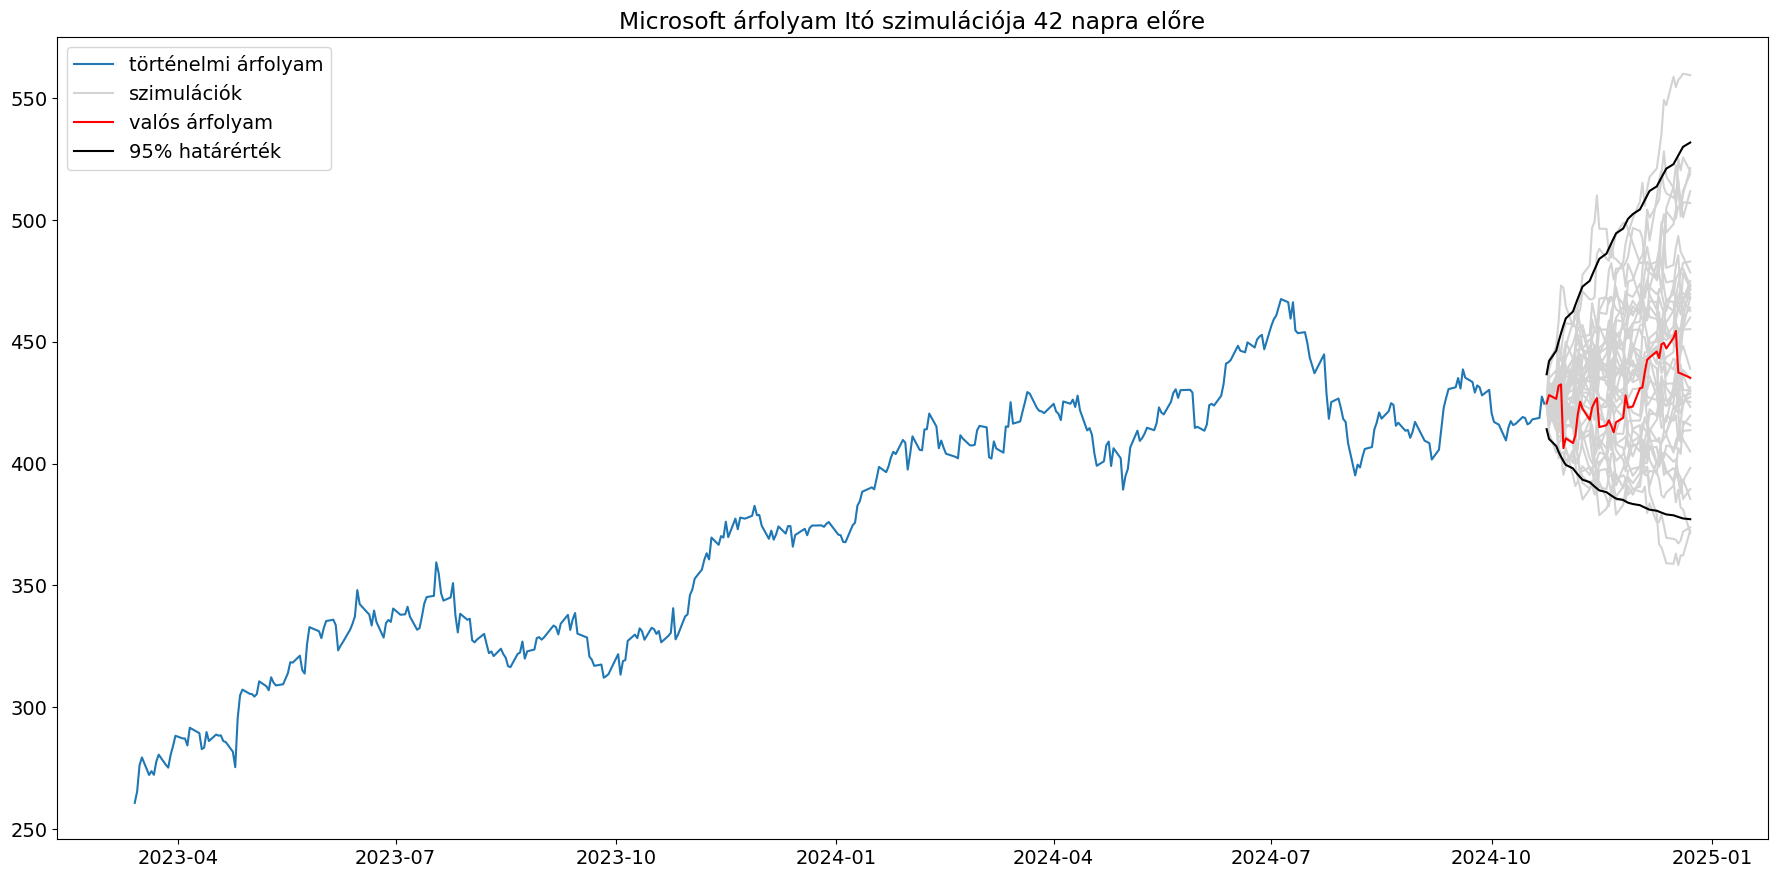

In [12]:
tortenelem = ar_msft["close"].values[1:-T]
tortenelem_ido = ar_msft["date"].values[1:-T]
valosag = ar_msft["close"].values[-T:]
valosag_ido = ar_msft["date"].values[-T:]
# szimuláció
szimulacio_ido = ar_msft["date"].values[-T:]
ido = T-1
bolyongasok = reszveny_arfolyam(
    kezdo_ar=tortenelem[-1], 
    ido=ido,
    atlag=mu_hat,
    szoras=sigma_hat,
    utvonal_szam=10000
)

plt.plot(tortenelem_ido, tortenelem, label="történelmi árfolyam")
for x in range(40):
    if x == 0:
        plt.plot(szimulacio_ido, bolyongasok[x], color="lightgrey", label="szimulációk")
    else:
        plt.plot(szimulacio_ido, bolyongasok[x], color="lightgrey")
plt.plot(valosag_ido, valosag, color="red", label="valós árfolyam")
plt.plot(szimulacio_ido, lower_prices, color="black", label="95% határérték")
plt.plot(szimulacio_ido, upper_prices, color="black")
plt.legend()
plt.title(f"Microsoft árfolyam Itó szimulációja {T} napra előre")
plt.tight_layout()
plt.show()

In [13]:
np.quantile([ x[-1] for x in bolyongasok ], 0.025)

376.2429049596603

In [14]:
np.quantile([ x[-1] for x in bolyongasok ], 0.975)

527.0628003709676